## Demo code for kernel density estimation

This notebook illustrates kernel density estimation, which is basically the same as kernel smoothing 
for regression. The estimator is given by 
$$ {\hat f}(x) = \frac{1}{nh^p} \sum_{i=1}^n K\left( \frac{X_i - x}{h}\right)$$
where $K(u)$ is a smoothing kernel that integrates to one. 
As in our previous notebook, we show the use of [different kernels](https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use), illustrating that it's the bandwidth that matters most, not the shape of the kernel.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def boxcar_kernel(u, h):
    return 0.5*np.array(np.fabs(u)/h < 1)

def triangular_kernel(u, h):
    return (1-np.abs(u)/h)*np.array(np.fabs(u)/h < 1)

def gaussian_kernel(u, h):
    return (1./np.sqrt(2*np.pi)) * np.exp(-(u)**2/(2*h**2))

def epanechnikov_kernel(u, h):
    return 0.75 * (1 - u**2/h**2)*np.array(np.fabs(u)/h < 1)

def tricube_kernel(u, h):
    return (70./81) * ((1 - np.abs(u)**3/h**3)**3)*np.array(np.fabs(u)/h < 1)

def kde_with_kernel(kernel, X, x, h):
    K = np.zeros(len(x)*len(X)).reshape(len(x), len(X))
    for j in np.arange(K.shape[1]):
        K[:,j] = kernel(x-X[j], h)
    fhat = (1/h) * np.mean(K, axis=1)
    return fhat


We read in the [Fiji earthquake data](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/quakes.html).

In [3]:
quakes = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/smoothing/fijiquakes.dat', sep='\s+')
quakes

,Obs.,lat,long,depth,mag,stations
0,1,-20.42,181.62,562,4.8,41
1,2,-20.62,181.03,650,4.2,15
2,3,-26.00,184.10,42,5.4,43
3,4,-17.97,181.66,626,4.1,19
4,5,-20.42,181.96,649,4.0,11
...,...,...,...,...,...,...
995,996,-25.93,179.54,470,4.4,22
996,997,-12.28,167.06,248,4.7,35
997,998,-20.13,184.20,244,4.5,34
998,999,-17.40,187.80,40,4.5,14


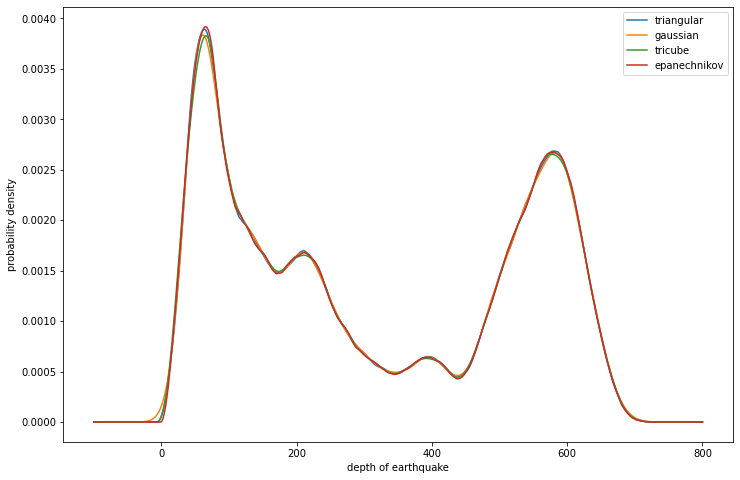

In [4]:
X = quakes['depth']
x = np.linspace(-100, 800, 500)

fhat_gaussian = kde_with_kernel(gaussian_kernel, X, x, 20)
fhat_tricube = kde_with_kernel(tricube_kernel, X, x, 50)
fhat_epanech = kde_with_kernel(epanechnikov_kernel, X, x, 40)
fhat_box = kde_with_kernel(boxcar_kernel, X, x, 35)
fhat_triangle = kde_with_kernel(triangular_kernel, X, x, 45)

plt.figure(figsize=(12, 8))

#plt.plot(x, fhat_box, label='boxcar')
plt.plot(x, fhat_triangle, label='triangular')
plt.plot(x, fhat_gaussian, label='gaussian')
plt.plot(x, fhat_tricube, label='tricube')
plt.plot(x, fhat_epanech, label='epanechnikov')

plt.xlabel('depth of earthquake')
plt.ylabel('probability density')
plt.legend()


Below we replicate a fancy way of visualizing the earthquake data, from [this site](https://towardsdatascience.com/how-to-make-stunning-interactive-maps-with-python-and-folium-in-minutes-e3aff3b0ed43).

In [5]:
import folium

def generate_color(magnitude):
    if magnitude <= 5:
        c_outline, c_fill = '#ffda79', '#ffda79'
        m_opacity, f_opacity = 0.2, 0.1
    else:
        c_outline, c_fill = '#c0392b', '#e74c3c'
        m_opacity, f_opacity = 1, 1
    return c_outline, c_fill, m_opacity, f_opacity

def generate_popup(magnitude, depth):
    return f'''<strong>Magnitude:</strong> {magnitude}<br><strong>Depth:</strong> {depth} km'''

quake_map = folium.Map(
    location=[-16.495477, 174.9663341],
    zoom_start=4,
    tiles='Stamen Terrain',
    width=1024,
    height=600
)

for _, row in quakes.iterrows():
    c_outline, c_fill, m_opacity, f_opacity = generate_color(row['mag'])
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        popup=generate_popup(row['mag'], row['depth']),
        color=c_outline,
        fill=True,
        fillColor=c_fill,
        opacity=m_opacity,
        fillOpacity=f_opacity,
        radius=(row['mag'] ** 3) / 15
    ).add_to(quake_map)
    
quake_map

